# Continuous Control

---

This notebook solves the Unity ML-Agents Reacher environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from ddpg_agent import Agent
import torch
import matplotlib.pyplot as plt

Next, we will start the environment!  **_Before running the code cell below_**, change the `filename` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
filename = "./Reacher_Linux/Reacher.x86_64"
env = UnityEnvironment(file_name=filename)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.16199999637901782


In [6]:
# When finished, close the environment.
env.close()

### 4. Train the agent using reinforcement learning.
This environment is considered solved when the average score over 100 episodes across all agents reaches 30, so the algorithm stops training at this point.

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
def ddpg(agent, env, n_episodes=2000, max_t=1000):
    """
    Train the agent
    Params
    ======
    agent (class): Instantiation of the agent
    env (int): Unity environment
    n_episodes (int): Maximum number of episodes to train over
    max_t (int): Number of intervals in each episode
    """
    
    scores_deque = deque(maxlen=100)
    scores = []                                             # initialize the score (for each agent)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations               # get the current state
        agent.reset()
        score = np.zeros(num_agents) 
        for t in range(max_t):
            actions = agent.act(states)                     # select an action
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations      # get the next state
            rewards = env_info.rewards                      # get the reward
            dones = env_info.local_done                     # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones) # train the agent
            score += rewards                                # update the score
            states = next_states                            # roll over the state to next time step
            if np.any(dones):                               # exit loop if episode finished
                break
                
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Episode Score: {:.2f}\tAverage Agent Score: {:.2f}'.format(
            i_episode, np.mean(np.mean(scores_deque)), np.mean(score)), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Episodes Score: {:.2f}'.format(
                i_episode, np.mean(np.mean(scores_deque))) + 30*' ')
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Using:  cuda:0
Episode 100	Average Episodes Score: 3.68                              
Episode 200	Average Episodes Score: 28.09                              
Episode 208	Average Episode Score: 30.07	Average Agent Score: 38.59
Environment solved in 108 episodes!	Average Score: 30.07


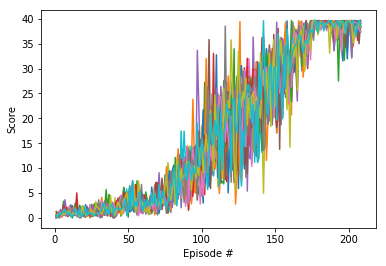

In [8]:
# Start Unity environment
env = UnityEnvironment(file_name=filename)

# Train agent and obtain scores
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)
scores = ddpg(agent, env)

# Close Unity environment
env.close()

# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

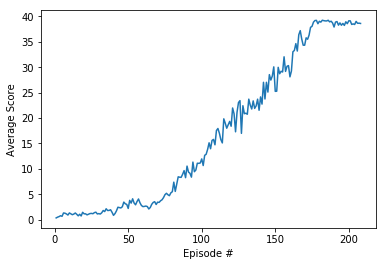

In [13]:
# Plot the average scores across all agents
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), np.mean(scores, axis=1))
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

# View trained agent

In [12]:
env = UnityEnvironment(file_name=filename)

agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
agent.reset()   
while True:
    actions = agent.act(states)                        # select an action
    env_info = env.step(actions)[brain_name]           # send the action to the environment
    next_states = env_info.vector_observations         # get the next state
    dones = env_info.local_done                        # see if episode has finished
    states = next_states                               # roll over the state to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
        
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
